# 시나리오
- 고객으로부터 구매하고자 하는 과일 사진을 받아서 가장 많이 요청한 과일을 판매하려고 함
- 고객이 보낸 사진을 사람이 일일이 분류하기는 너무 힘듦
- 미리 과일 분류기를 만든다고 하더라도 고객이 보내는 사진이 그에 맞을 지 확실하지 않음
- 과일 사진이 어떤 과일인지에 대한 정답(타겟)을 알지 못하는 상황에서 어떻게 분류를 해야 할까? 

## 타겟을 모르는 비지도 학습
- 정답(타겟)을 모르는 사진을 종류별로 분류하고자 함
- 정답을 모르는 상황에서 사용하는 머신러닝 알고리즘
- 사진은 픽셀값으로 처리되므로 이를 이용하여 사진을 분류하도록 할 수 있음

### 1) 과일 사진 데이터 준비
- 캐글에 공개된 과일 데이터 셋 사용(https://www.kaggle.com/moltean/fruits)
- 실습을 위해 가공된 파일을 사용(fruits_300.npy)
- 사과, 바나나, 파인애플을 담고 있는 흑백사진 데이터
- 넘파이 배열의 기본 저장포멧(npy)로 저장되어 있음

In [1]:
# 데이터 불러오기
import numpy as np
import matplotlib.pyplot as plt

fruits = np.load('fruits_300.npy')

In [2]:
# 배열의 형태 확인
fruits.shape

(300, 100, 100)

##### 결과
- 샘플의 갯수, 이미지 높이, 이미지 너비
- 이미지 크기가 100x100
- 각 픽셀은 넘파이 배열의 원소 하나에 대응(배열의 크기가 100x100이라는 의미)

In [3]:
# 첫 번째 이미지의 첫 번째 행 출력해보기(3차원 배열의 요소 접근)
fruits[0, 0, :] #fruits[0, 0] 

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   2,   1,   2,   2,   2,   2,   2,   2,   1,   1,
         1,   1,   1,   1,   1,   1,   2,   3,   2,   1,   2,   1,   1,
         1,   1,   2,   1,   3,   2,   1,   3,   1,   4,   1,   2,   5,
         5,   5,  19, 148, 192, 117,  28,   1,   1,   2,   1,   4,   1,
         1,   3,   1,   1,   1,   1,   1,   2,   2,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1], dtype=uint8)

##### 결과
- 첫 번째 행에 있는 픽셀 100개에 들어있는 값 출력
- 흑백 사진을 담고 있으며 0 ~ 255까지의 정수값을 가짐

#### imshow() 사용
- 이미지의 픽셀이 저장된 넘파이 배열로 이미지를 그려주는 함수
- 흑백 이미지이므로 cmap매개변수에 'gray'(그레이스케일)설정
- 픽셀 값이 0에 가까울수록 검정색으로 표현

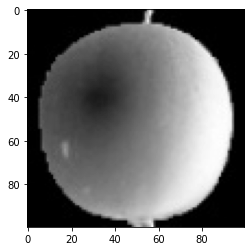

In [4]:
plt.imshow(fruits[0], cmap='gray')
plt.show()

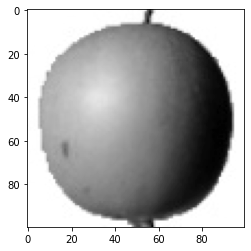

In [5]:
# 이미지 값 처리를 알맞게 할 수 있도록 흑백을 반전
plt.imshow(fruits[0], cmap='gray_r')
plt.show()

##### 반전 이유
- 데이터셋에 들어있던 값은 실제 이미지를 넘파이 배열로 저장할 때 반전된 값
- 저장된 이미지는 사과가 아닌 바탕이 검은색(255)값에 가깝고 관심 대상인 사과의 값이 흰색(0)에 가까움
- 사과를 식별하기 위해 컴퓨터에서 값을 처리하려면 관심 대상의 값이 중요하고 바탕은 중요하지 않기 때문에 이를 반전시킴

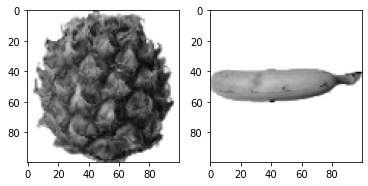

In [6]:
# 100번과 200번의 과일 이미지를 출력
fig, axs = plt.subplots(1, 2)
axs[0].imshow(fruits[100], cmap='gray_r')
axs[1].imshow(fruits[200], cmap='gray_r')
plt.show()

- 샘플 데이터는 사과, 파인애플, 바나나 순서대로 100개씩 들어있음
- 실무에서 데이터가 위와 같이 나누어져 있을 상황은 거의 없음(실제로는 더 작업이 많음)

#### 이미지가 넘파이 배열로 저장된 개념
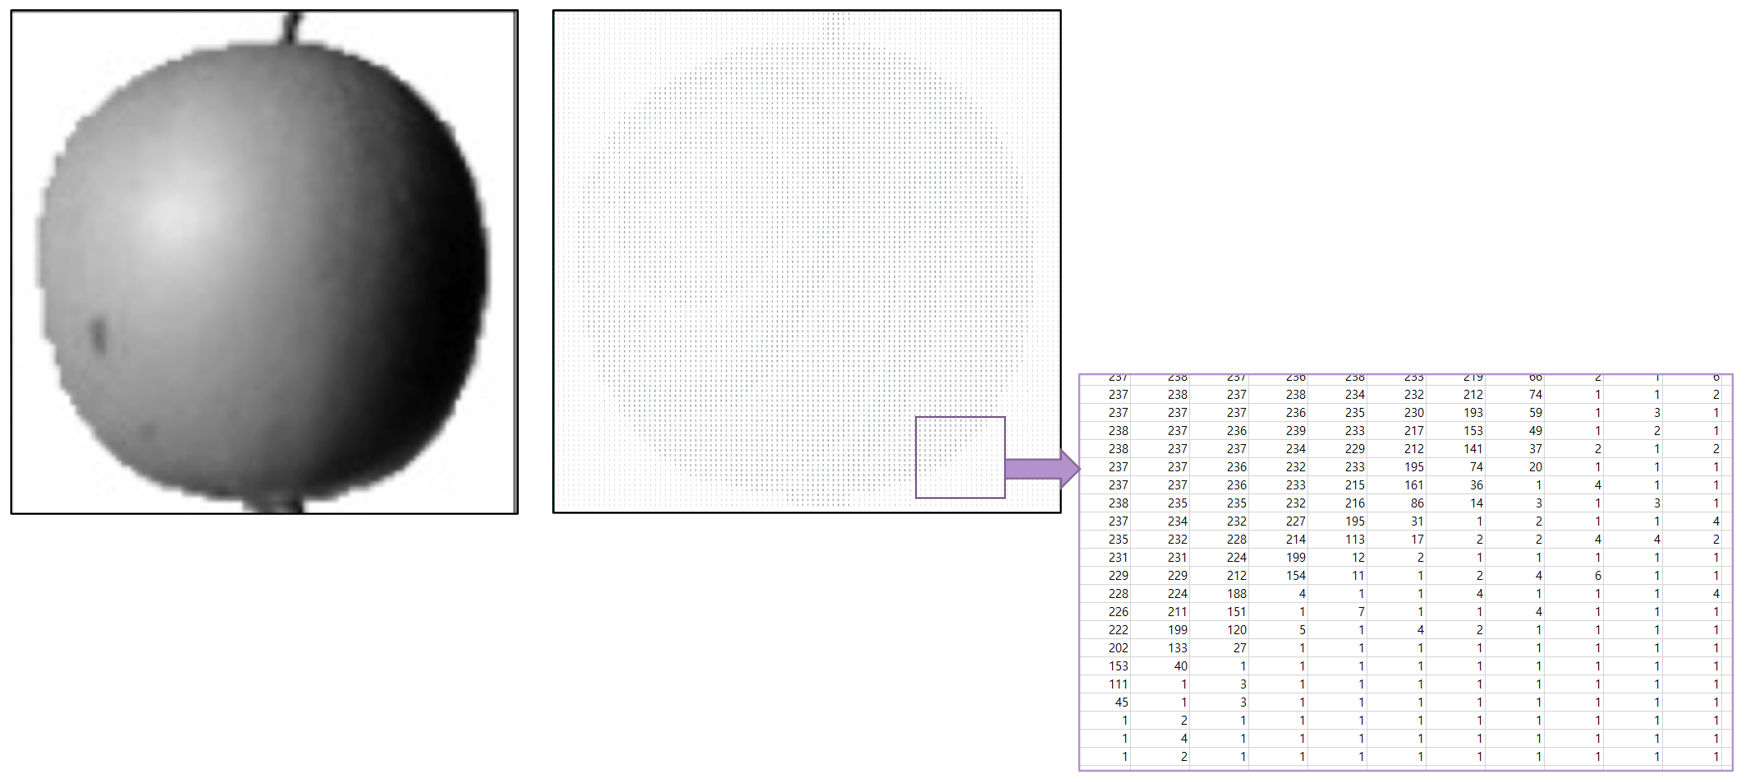

### 2) 픽셀 값 분석


In [7]:
# 사용하기 쉽도록 각 과일 데이터를 나눈다
apple = fruits[0:100].reshape(-1, 100*100)
pineapple = fruits[100:200].reshape(-1, 100*100)
banana = fruits[200:300].reshape(-1, 100*100)

##### 설명
- reshape() 사용 시 첫 번째 차원을 -1로 지정하면 자동으로 남은 차원을 할당(이 예제에서 첫 번째 차원은 샘플 개수)
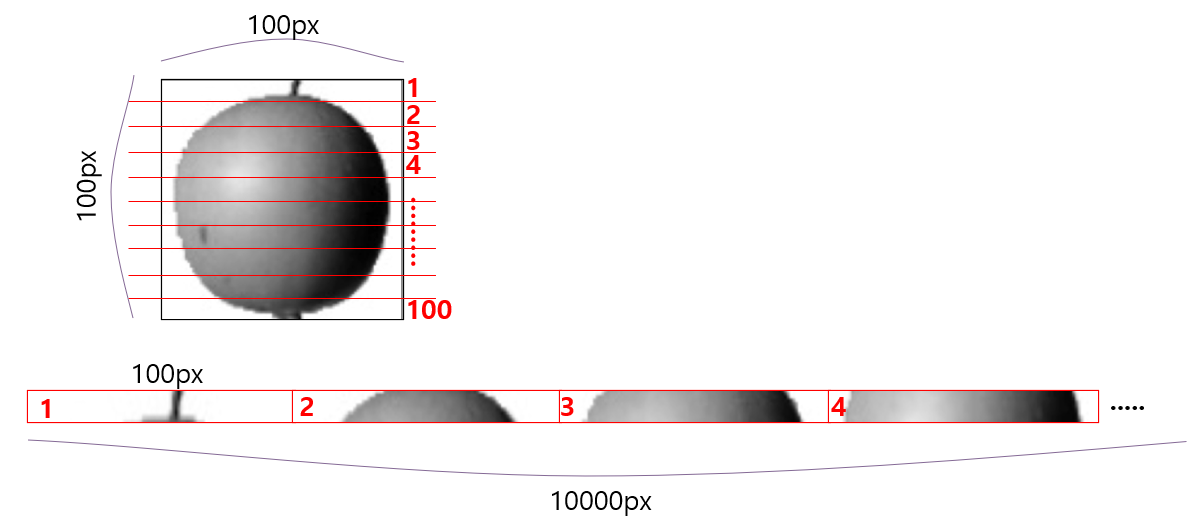

In [8]:
# 나누어진 데이터 차원 확안
apple.shape, pineapple.shape, banana.shape

((100, 10000), (100, 10000), (100, 10000))

In [9]:
apple

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [10]:
# apple 데이터 샘플의 픽셀 평균값 확인(100개의 사과 이미지에 대한 픽셀값 평균)
apple.mean(axis=1)

array([ 88.3346,  97.9249,  87.3709,  98.3703,  92.8705,  82.6439,
        94.4244,  95.5999,  90.681 ,  81.6226,  87.0578,  95.0745,
        93.8416,  87.017 ,  97.5078,  87.2019,  88.9827, 100.9158,
        92.7823, 100.9184, 104.9854,  88.674 ,  99.5643,  97.2495,
        94.1179,  92.1935,  95.1671,  93.3322, 102.8967,  94.6695,
        90.5285,  89.0744,  97.7641,  97.2938, 100.7564,  90.5236,
       100.2542,  85.8452,  96.4615,  97.1492,  90.711 , 102.3193,
        87.1629,  89.8751,  86.7327,  86.3991,  95.2865,  89.1709,
        96.8163,  91.6604,  96.1065,  99.6829,  94.9718,  87.4812,
        89.2596,  89.5268,  93.799 ,  97.3983,  87.151 ,  97.825 ,
       103.22  ,  94.4239,  83.6657,  83.5159, 102.8453,  87.0379,
        91.2742, 100.4848,  93.8388,  90.8568,  97.4616,  97.5022,
        82.446 ,  87.1789,  96.9206,  90.3135,  90.565 ,  97.6538,
        98.0919,  93.6252,  87.3867,  84.7073,  89.1135,  86.7646,
        88.7301,  86.643 ,  96.7323,  97.2604,  81.9424,  87.1

##### 결과 이미지
- axis는 배열의 축을 의미
- axis=1은 열 방향으로 적용, axis=0은 행 방향으로 적용
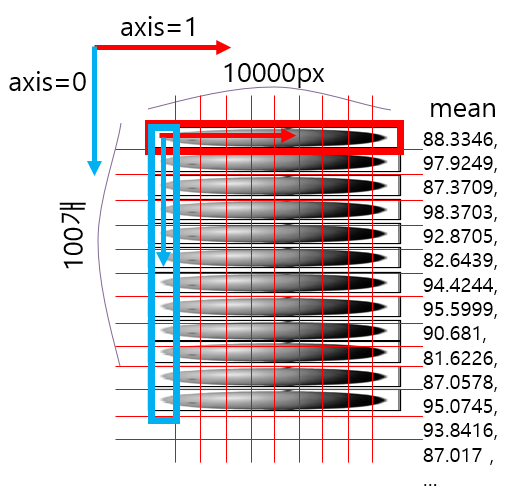

### 히스토그램 시각화
- 히스토그램은 구간별로 값이 발생한 빈도를 나타내는 그래프
- x축은 값의 구간(계급)
- y축은 발생 빈도(도수)

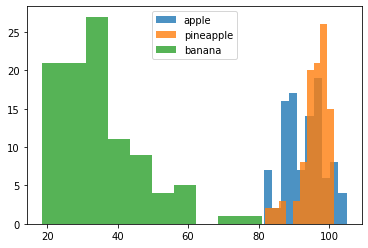

In [11]:
import matplotlib.pyplot as plt

plt.hist(np.mean(apple, axis=1), alpha=0.8)
plt.hist(np.mean(pineapple, axis=1), alpha=0.8)
plt.hist(np.mean(banana, axis=1), alpha=0.8)
plt.legend(['apple', 'pineapple', 'banana'])
plt.show()

##### 해석
- 바나나 사진의 평균값은 40아래에 집중 되어 있음
- 사과와 파인애플은 90~100사이에 모여있음
- 바나나는 파인애플과 사과와 픽셀 평균만으로 확실하게 구분됨
- 사과와 파인애플은 픽셀 평균만으로 구분하기 어려움

### 전체 샘플의 각 픽셀의 평균을 계산
- 세 가지 과일은 모양이 다르기 때문에 픽셀값이 높은 위치가 다를 것으로 예상
- 픽셀의 평균은 axis=0으로 지정

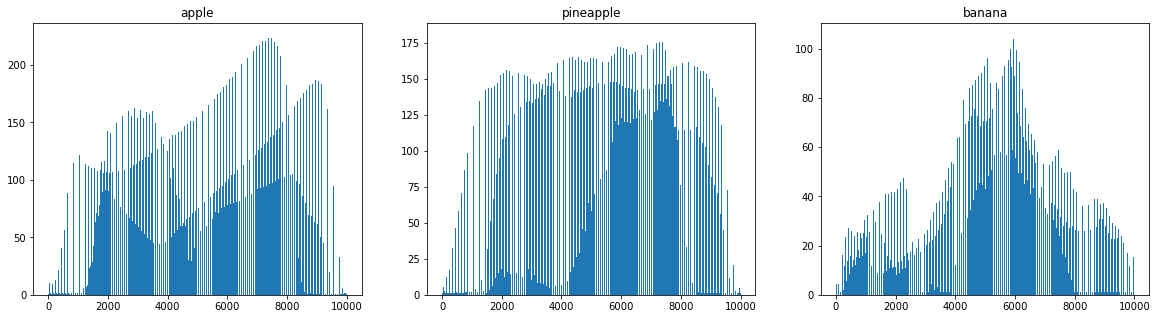

In [12]:
# 서브플롯을 이용하여 세 가지 과일에 대한 히스토그램 그리기(약간의 시간이 소요됨)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].set_title('apple')
axs[0].bar(range(10000), np.mean(apple, axis=0))
axs[1].set_title('pineapple')
axs[1].bar(range(10000), np.mean(pineapple, axis=0))
axs[2].set_title('banana')
axs[2].bar(range(10000), np.mean(banana, axis=0))
plt.show()

##### 해석
- 과일마다 값이 높은 구간이 다름
- 사과는 사진 아래쪽으로 갈수록 값이 높아짐
- 파인애플은 비교적 고르면서 높음
- 바나나는 중앙 픽셀값이 높음

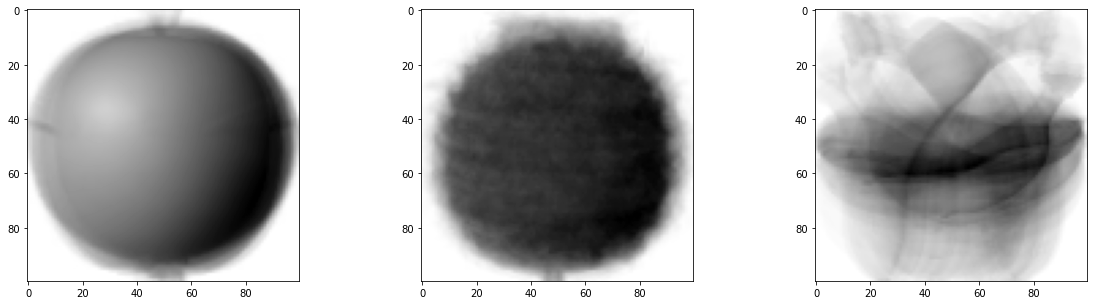

In [13]:
# 픽셀 평균값을 100x100크기로 변경하여 이미지처럼 출력하여 그래프와 비교
# 각 과일의 모든 이미지를 합쳐놓은 개념(대표 이미지)
apple_mean = np.mean(apple, axis=0).reshape(100, 100)
pineapple_mean = np.mean(pineapple, axis=0).reshape(100, 100)
banana_mean = np.mean(banana, axis=0).reshape(100, 100)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(apple_mean, cmap='gray_r')
axs[1].imshow(pineapple_mean, cmap='gray_r')
axs[2].imshow(banana_mean, cmap='gray_r')
plt.show()

##### 해석
- 세 과일은 픽셀 위치에 따라 값의 크기 차이가 보임
- 대표 이미지라고 할 수 있는 사진과 가장 가까운 것으로 각 과일을 구분할 수 있을 것 같다.

### 평균값과 가까운 사진 고르기
- 사과 사진의 평균값인 apple_mean과 가장 가까운 사진을 골라본다.
- 절대값 오차를 사용
- fruits배열에 있는 모든 샘플에서 apple_means를 빼고 절대값의 평균을 계산

In [14]:
# fruits배열에 있는 샘플들의 절대값의 평균 구하기
# 샘플들의 절대값 구하기
abs_diff = np.abs(fruits - apple_mean)
abs_diff[:3]

array([[[0.01, 0.01, 0.01, ..., 0.  , 0.  , 0.  ],
        [0.01, 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]],

       [[0.01, 0.01, 0.01, ..., 0.  , 0.  , 0.  ],
        [0.01, 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]],

       [[0.01, 0.01, 0.01, ..., 0.  , 0.  , 0.  ],
        [0.01, 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]]])

In [15]:
# 절대값의 평균 구하기
abs_mean = np.mean(abs_diff, axis=(1,2)) # axis축. 면(0), 행(1), 열(2)
abs_mean[:3]

array([17.37576 , 13.508874, 17.183394])

In [16]:
# 결과 배열의 크기 확인
abs_mean.shape

(300,)

In [17]:
for i in range(10):
    for j in range(10):
        print(i, j, i*10 + j)

0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
0 6 6
0 7 7
0 8 8
0 9 9
1 0 10
1 1 11
1 2 12
1 3 13
1 4 14
1 5 15
1 6 16
1 7 17
1 8 18
1 9 19
2 0 20
2 1 21
2 2 22
2 3 23
2 4 24
2 5 25
2 6 26
2 7 27
2 8 28
2 9 29
3 0 30
3 1 31
3 2 32
3 3 33
3 4 34
3 5 35
3 6 36
3 7 37
3 8 38
3 9 39
4 0 40
4 1 41
4 2 42
4 3 43
4 4 44
4 5 45
4 6 46
4 7 47
4 8 48
4 9 49
5 0 50
5 1 51
5 2 52
5 3 53
5 4 54
5 5 55
5 6 56
5 7 57
5 8 58
5 9 59
6 0 60
6 1 61
6 2 62
6 3 63
6 4 64
6 5 65
6 6 66
6 7 67
6 8 68
6 9 69
7 0 70
7 1 71
7 2 72
7 3 73
7 4 74
7 5 75
7 6 76
7 7 77
7 8 78
7 9 79
8 0 80
8 1 81
8 2 82
8 3 83
8 4 84
8 5 85
8 6 86
8 7 87
8 8 88
8 9 89
9 0 90
9 1 91
9 2 92
9 3 93
9 4 94
9 5 95
9 6 96
9 7 97
9 8 98
9 9 99


In [18]:
# 절대값 평균을 가장 작은 순서대로 100개를 가져옴(apple_mean과 오차가 가장 작은 샘플 100개를 고르는 것)

# abs_mean에서 오름차순으로 나열한 abs_mean인덱스를 반환
apple_index = np.argsort(abs_mean)[:100]
apple_index

array([33, 48, 70, 57, 87, 12, 78, 59,  1, 74, 86, 38, 50, 92, 69, 27, 68,
       30, 66, 24, 76, 98, 15, 84, 47, 90,  3, 94, 53, 23, 14, 71, 32,  7,
       73, 36, 55, 77, 21, 10, 17, 39, 99, 95, 11, 35, 65,  6, 61, 22, 56,
       89,  2, 13, 80,  0, 97,  4, 58, 34, 40, 43, 75, 82, 54, 16, 31, 49,
       93, 37, 63, 64, 41, 28, 67, 25, 96,  8, 83, 46, 19, 79, 72,  5, 85,
       29, 20, 60, 81,  9, 45, 51, 88, 62, 91, 26, 52, 18, 44, 42],
      dtype=int64)

In [19]:
apple_index.shape

(100,)

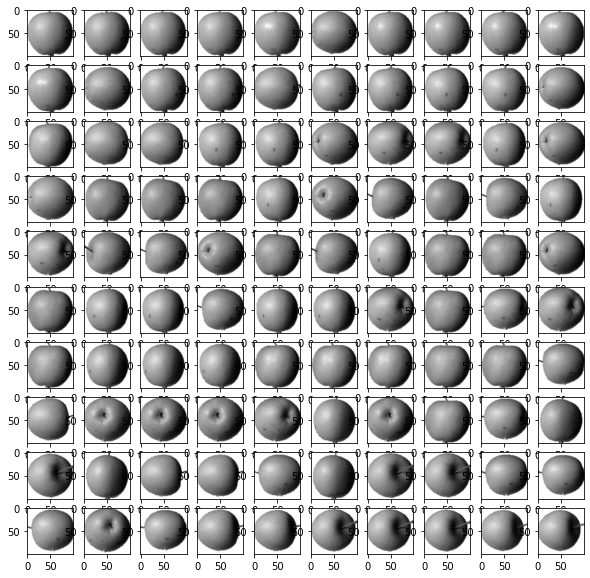

In [20]:
# 선택된 인덱스에 해당하는 샘플을 10 x 10 격자로 그래프 그리기
fig, axs = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        axs[i, j].imshow(fruits[apple_index[i*10 + j]], cmap='gray_r')
        #axs[i, j].axis('off')
plt.show()

##### 해석
- apple_mean과 가장 가까운 사진 100개가 모두 사과
- axis('off') 좌표축 표시 안함

### 정리
- 흑백 사진을 이루고 있는 픽셀값을 사용하여 과일 사진을 수집하는 작업 진행
- 비슷한 색플끼리 그룹으로 모으는 작업을(군집. Clustering)이라고 함
- 대표적인 비지도 학습 작업 중 하나
- 군집 알고리즘에서 만든 그룹을 클러스터(Cluster)라고 부름


- 사과, 파인애플, 바나나가 데이터셋에 있는 것을 알고 있었음(정답 데이터를 가진 상태)
- 각 과일의 사진 픽셀의 평균 값을 계산하여 가장 가까운 과일을 찾을 수 있었음
- 실제 비지도 학습에서라면 지금과 같이 샘플의 평균값을 미리 찾아둘수가 없음
- 타겟을 모르는 세 과일의 평균값을 K-평균 알고리즘으로 구할 수 있음

### 실습(비슷한 샘플끼리 모으기)
#### 군집은 비슷한 샘플끼리 모으는 작업
- 고객이 업로드한 과일 사진을 자동으로 분류해야 함
- 어떤 과일 사진이 업로드 될지 예상할 수 없음(타겟을 준비하여 분류모델 훈련 불가)
- 타겟이 없을 때 데이터에 있는 패턴을 찾거나 데이터 구조를 파악하는 것이 비지도 학습
- 알고리즘 스스로 데이터의 구성을 파악하도록 하는 것
- 대표적 비지도 학습 문제는 '군집'

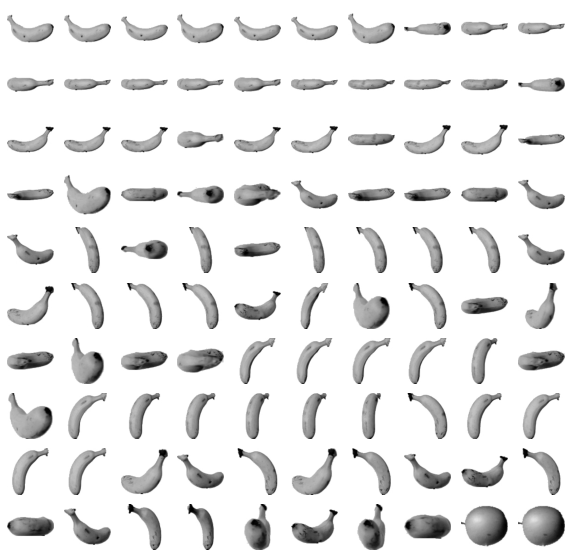

In [21]:
#### 바나나 사진의 평균 banana_mean과 비슷한 사진 100장을 찾아 출력하기
abs_diff = np.abs(fruits - banana_mean)
abs_mean = np.mean(abs_diff, axis=(1,2))

banana_index = np.argsort(abs_mean)[:100]
fig, axs = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        axs[i, j].imshow(fruits[banana_index[i*10 + j]], cmap='gray_r')
        axs[i, j].axis('off')
plt.show()

##### 해석
- 대부분 바나나를 잘 선택한 것 같은데 사과가 두 개 선택되었음